# KLSE - Preprocess, Cluster/Categorize the Stocks

In [44]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import datetime as dt
import calendar as cal
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# Load the stock master file

In [3]:
df_stocks = pd.read_csv('../dataset/KLSE_investing.csv', index_col=['name'])
df_stocks.head(10)

,link,last,high,low,change,change_percent,volume
name,,,,,,,
Priceworth International,https://www.investing.com/equities/priceworth-...,0.045,0.055,0.045,-0.005,-10.00%,223.12M
Sapura Energy,https://www.investing.com/equities/sapurakenca...,0.335,0.345,0.335,0.000,0.00%,53.62M
Borneo Oil,https://www.investing.com/equities/borneo-oil-bhd,0.055,0.060,0.055,0.000,0.00%,50.93M
MY EG Services,https://www.investing.com/equities/my-eg-servi...,1.630,1.700,1.620,-0.020,-1.21%,35.62M
Tiger Synergy Bhd,https://www.investing.com/equities/tiger-syner...,0.070,0.075,0.065,-0.005,-6.67%,29.80M
Nova MSC,https://www.investing.com/equities/nova-msc-bhd,0.160,0.160,0.145,0.005,+3.23%,22.05M
Frontken Corp,https://www.investing.com/equities/frontken-co...,0.920,0.960,0.915,0.000,0.00%,20.90M
Globaltec Formation,https://www.investing.com/equities/globaltec-f...,0.040,0.045,0.035,-0.005,-11.11%,19.77M
AirAsia X,https://www.investing.com/equities/airasia-x-bhd,0.290,0.305,0.290,-0.010,-3.33%,19.08M


# Load dividends file

In [4]:
df_dividends = pd.read_csv('../dataset/KLSE_dividends_investing.csv')
df_dividends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2315 entries, 0 to 2314
Data columns (total 6 columns):
code                2315 non-null object
name                2315 non-null object
ex_dividend_date    2315 non-null object
dividend            2315 non-null float64
payment_date        2315 non-null object
yield               2315 non-null object
dtypes: float64(1), object(5)
memory usage: 108.6+ KB


In [5]:
df_dividends.describe()

,dividend
count,2315.000000
mean,0.100847
std,0.186474
min,0.000900
25%,0.020000
50%,0.050000
75%,0.100000
max,2.700000


In [6]:
df_dividends.columns

Index(['code', 'name', 'ex_dividend_date', 'dividend', 'payment_date',
       'yield'],
      dtype='object')

# Display some data

In [7]:
df_dividends.head(10)

,code,name,ex_dividend_date,dividend,payment_date,yield
0,5218,Sapura Energy Bhd (SAEN),"Apr 12, 2017",0.0100,"Apr 28, 2017",2.94%
1,5218,Sapura Energy Bhd (SAEN),"Jul 29, 2015",0.0135,"Aug 28, 2015",0.72%
2,138,MY EG Services Bhd (MYEG),"Apr 24, 2018",0.0170,"May 25, 2018",1.30%
3,138,MY EG Services Bhd (MYEG),"Jan 04, 2018",0.0170,"Feb 06, 2018",0.63%
4,138,MY EG Services Bhd (MYEG),"Apr 21, 2017",0.0137,"May 24, 2017",0.64%
5,138,MY EG Services Bhd (MYEG),"Dec 23, 2016",0.0120,"Jan 25, 2017",0.74%
6,138,MY EG Services Bhd (MYEG),"Apr 22, 2016",0.0120,"May 24, 2016",0.56%
7,138,MY EG Services Bhd (MYEG),"Jan 04, 2016",0.0095,"Feb 04, 2016",0.44%
8,128,Frontken Corporation Bhd (FRKN),"Sep 15, 2017",0.0050,"Oct 04, 2017",0.60%
9,9385,Lay Hong Bhd (LAYH),"Oct 18, 2018",0.0050,"Nov 15, 2018",0.79%


## Preprocess the data for training

In [8]:
df_dividends_train = df_dividends.copy()
df_dividends_train['dividend_year'] = pd.to_datetime(df_dividends_train['ex_dividend_date'], format='%b %d, %Y').dt.year
#df_dividends_train = df_dividends.drop(['ex_dividend_date', 'payment_date'], axis=1)
# df_dividends_train['yield'] = df_dividends_train['yield'].map({'-': '0'})
df_dividends_train['yield'] = df_dividends_train['yield'].replace('-','0')
df_dividends_train['yield'] = df_dividends_train['yield'].str.rstrip('%').astype('float')
df_dividends_train.head()

,code,name,ex_dividend_date,dividend,payment_date,yield,dividend_year
0,5218,Sapura Energy Bhd (SAEN),"Apr 12, 2017",0.0100,"Apr 28, 2017",2.94,2017
1,5218,Sapura Energy Bhd (SAEN),"Jul 29, 2015",0.0135,"Aug 28, 2015",0.72,2015
2,138,MY EG Services Bhd (MYEG),"Apr 24, 2018",0.0170,"May 25, 2018",1.30,2018
3,138,MY EG Services Bhd (MYEG),"Jan 04, 2018",0.0170,"Feb 06, 2018",0.63,2018
4,138,MY EG Services Bhd (MYEG),"Apr 21, 2017",0.0137,"May 24, 2017",0.64,2017


### Apply one-hot encoding to code

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
code = df_dividends_train['code']
code_encoded = label_encoder.fit_transform(code)
code_encoded

array([293, 293,  65, ...,  48, 231, 231])

In [15]:
print(label_encoder.classes_)

['0001' '0011' '0012' '0023' '0024' '0028' '0032' '0037' '0039' '0040'
 '0050' '0053' '0054' '0056' '0059' '0084' '0089' '0090' '0093' '0099'
 '0100' '0101' '0104' '0105' '0106' '0108' '0111' '0112' '0113' '0120'
 '0123' '0127' '0136' '0146' '0148' '0151' '0153' '0158' '0161' '0163'
 '0171' '0172' '0178' '0179' '0182' '0183' '0185' '0186' '0191' '0193'
 '0195' '1007' '1015' '1023' '1058' '1066' '1082' '1147' '1155' '1163'
 '1171' '1198' '128' '1295' '1368' '138' '1481' '149' '1503' '1538' '1562'
 '1619' '1651' '166' '168' '1724' '1783' '1818' '1899' '1929' '1961'
 '1996' '2' '2038' '2054' '2062' '2089' '21' '2127' '2135' '2186' '2194'
 '2216' '2224' '2291' '2305' '2445' '2453' '2488' '2542' '2569' '2593'
 '2607' '2658' '2674' '2755' '2771' '2828' '2836' '2852' '2879' '2925'
 '2984' '3026' '3034' '3042' '3069' '3107' '3158' '3174' '3182' '3204'
 '3239' '3247' '3255' '3298' '3301' '3336' '3379' '3379PA' '3395' '3417'
 '3476' '35' '3514' '3522' '3611' '3662' '3689' '3719' '3794' '3816'
 '

In [16]:
one_hot_encoder = OneHotEncoder()
code_1hot = one_hot_encoder.fit_transform(code_encoded.reshape(-1,1))
code_1hot

<2315x585 sparse matrix of type '<class 'numpy.float64'>'
	with 2315 stored elements in Compressed Sparse Row format>

In [17]:
code_1hot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Use LabelBinarizer

In [18]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
code_1hot = label_binarizer.fit_transform(code)
code_1hot

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Build the preprocessing pipelines

### Custom Data Processor

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
import numpy.core.defchararray as npf

In [32]:
df_dividends = pd.read_csv('../dataset/KLSE_dividends_investing.csv')
df_dividends.info()
df_dividends.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2315 entries, 0 to 2314
Data columns (total 6 columns):
code                2315 non-null object
name                2315 non-null object
ex_dividend_date    2315 non-null object
dividend            2315 non-null float64
payment_date        2315 non-null object
yield               2315 non-null object
dtypes: float64(1), object(5)
memory usage: 108.6+ KB


,code,name,ex_dividend_date,dividend,payment_date,yield
0,5218,Sapura Energy Bhd (SAEN),"Apr 12, 2017",0.0100,"Apr 28, 2017",2.94%
1,5218,Sapura Energy Bhd (SAEN),"Jul 29, 2015",0.0135,"Aug 28, 2015",0.72%
2,138,MY EG Services Bhd (MYEG),"Apr 24, 2018",0.0170,"May 25, 2018",1.30%
3,138,MY EG Services Bhd (MYEG),"Jan 04, 2018",0.0170,"Feb 06, 2018",0.63%
4,138,MY EG Services Bhd (MYEG),"Apr 21, 2017",0.0137,"May 24, 2017",0.64%
5,138,MY EG Services Bhd (MYEG),"Dec 23, 2016",0.0120,"Jan 25, 2017",0.74%
6,138,MY EG Services Bhd (MYEG),"Apr 22, 2016",0.0120,"May 24, 2016",0.56%
7,138,MY EG Services Bhd (MYEG),"Jan 04, 2016",0.0095,"Feb 04, 2016",0.44%
8,128,Frontken Corporation Bhd (FRKN),"Sep 15, 2017",0.0050,"Oct 04, 2017",0.60%
9,9385,Lay Hong Bhd (LAYH),"Oct 18, 2018",0.0050,"Nov 15, 2018",0.79%


In [38]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [39]:

code_index, name_index, ex_dividend_date_index, dividend_index, payment_date_index, yield_index = 0, 1, 2, 3, 4, 5 

class KlseDataPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        
        ## Create dividend_year attribute
        # print(X[:, ex_dividend_date_index])
        dividend_year = pd.to_datetime(X[:, ex_dividend_date_index], format='%b %d, %Y').year
        # dividend_year = np.array(dividend_year, dtype=np.integer)
        # print(dividend_year)
        
        ## Convert yield to float
        # yields = X[:, yield_index]
        # print(yields)
        # print(yields[yields == '-'])
        X[:, yield_index][X[:, yield_index] == '-'] = '0'
        # print(yields[yields == '0'])
        X[:, yield_index] = npf.rstrip(np.array(X[:, yield_index], dtype='str'), '%').astype(np.float)
        # print(yields)
        
        ## Drop string fields
        X = np.delete(X, [code_index, name_index, ex_dividend_date_index, payment_date_index], axis=1)
        
        result = np.c_[X, dividend_year]
        print(result)
        return result
    
        # X['dividend_year'] = pd.to_datetime(X['ex_dividend_date'], format='%b %d, %Y').dt.year
        # X['yield'] = X['yield'].replace('-','0')
        # X['yield'] = X['yield'].str.rstrip('%').astype('float')
        # return X.drop(['ex_dividend_date','payment_date', 'code', 'name'], axis=1)   # Drop non numerical columns

In [40]:
df_dividends = pd.read_csv('../dataset/KLSE_dividends_investing.csv')
klse_data_preprocessor = KlseDataPreprocessor()
klse_data_preprocessor.transform(df_dividends.values)

[[0.01 2.94 2017]
 [0.0135 0.72 2015]
 [0.017 1.3 2018]
 ...
 [0.0095 2.84 2018]
 [0.049 5.1 2018]
 [0.06 6.12 2018]]


array([[0.01, 2.94, 2017],
       [0.0135, 0.72, 2015],
       [0.017, 1.3, 2018],
       ...,
       [0.0095, 2.84, 2018],
       [0.049, 5.1, 2018],
       [0.06, 6.12, 2018]], dtype=object)

### Check scikit version

In [41]:
print(list(df_dividends))
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))


['code', 'name', 'ex_dividend_date', 'dividend', 'payment_date', 'yield']
The nltk version is 3.2.5.
The scikit-learn version is 0.19.2.


### Build the pipelines

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from future_encoders import OneHotEncoder

df_dividends = pd.read_csv('../dataset/KLSE_dividends_investing.csv')
df_dividends['code_id'] = df_dividends.groupby('code').ngroup()
#df_dividends.groupby(['code_id','year']).agg({'amount': np.sum})

standard_attribs = list(df_dividends)
code_attrib = ["code"]

#print(standard_attribs)
# print(df_dividends)

standard_pipeline = Pipeline([
        ('selector', DataFrameSelector(standard_attribs)),
        ('preprocessor', KlseDataPreprocessor()),
        ('scaler', StandardScaler()),
    ])

code_pipeline = Pipeline([
        ('selector', DataFrameSelector(code_attrib)),
        ('code_encoder', OneHotEncoder(sparse=False))
    ])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("standard_attribs", standard_pipeline)
    ])

df_prepared = full_pipeline.fit_transform(df_dividends)
df_prepared

df_dividends.head(10)

[[0.01 2.94 293 2017]
 [0.0135 0.72 293 2015]
 [0.017 1.3 65 2018]
 ...
 [0.0095 2.84 48 2018]
 [0.049 5.1 231 2018]
 [0.06 6.12 231 2018]]


/Users/mengwangk/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,code,name,ex_dividend_date,dividend,payment_date,yield,code_id
0,5218,Sapura Energy Bhd (SAEN),"Apr 12, 2017",0.0100,"Apr 28, 2017",2.94%,293
1,5218,Sapura Energy Bhd (SAEN),"Jul 29, 2015",0.0135,"Aug 28, 2015",0.72%,293
2,138,MY EG Services Bhd (MYEG),"Apr 24, 2018",0.0170,"May 25, 2018",1.30%,65
3,138,MY EG Services Bhd (MYEG),"Jan 04, 2018",0.0170,"Feb 06, 2018",0.63%,65
4,138,MY EG Services Bhd (MYEG),"Apr 21, 2017",0.0137,"May 24, 2017",0.64%,65
5,138,MY EG Services Bhd (MYEG),"Dec 23, 2016",0.0120,"Jan 25, 2017",0.74%,65
6,138,MY EG Services Bhd (MYEG),"Apr 22, 2016",0.0120,"May 24, 2016",0.56%,65
7,138,MY EG Services Bhd (MYEG),"Jan 04, 2016",0.0095,"Feb 04, 2016",0.44%,65
8,128,Frontken Corporation Bhd (FRKN),"Sep 15, 2017",0.0050,"Oct 04, 2017",0.60%,62
9,9385,Lay Hong Bhd (LAYH),"Oct 18, 2018",0.0050,"Nov 15, 2018",0.79%,569


In [496]:
df_prepared.shape

(2315, 4)

### Categorize the stocks

6123.037889465623


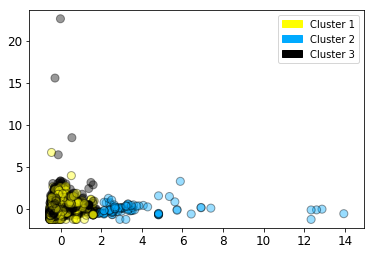

In [503]:
from sklearn.cluster import KMeans
from adspy_shared_utilities import plot_labelled_scatter

kmeans = KMeans(n_clusters = 3)
kmeans.fit(df_prepared)
print(kmeans.inertia_)

plot_labelled_scatter(df_prepared, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'])

